In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Background of Neural Networks

## 1. What is a Neural Network?

A **neural network** is a computational model composed of layers of simple mathematical functions, called **neurons**, that are composed to approximate complex input-output relationships. Each artificial neuron computes a weighted sum of its inputs, applies a non-linear activation function, and passes the result to the next layer.

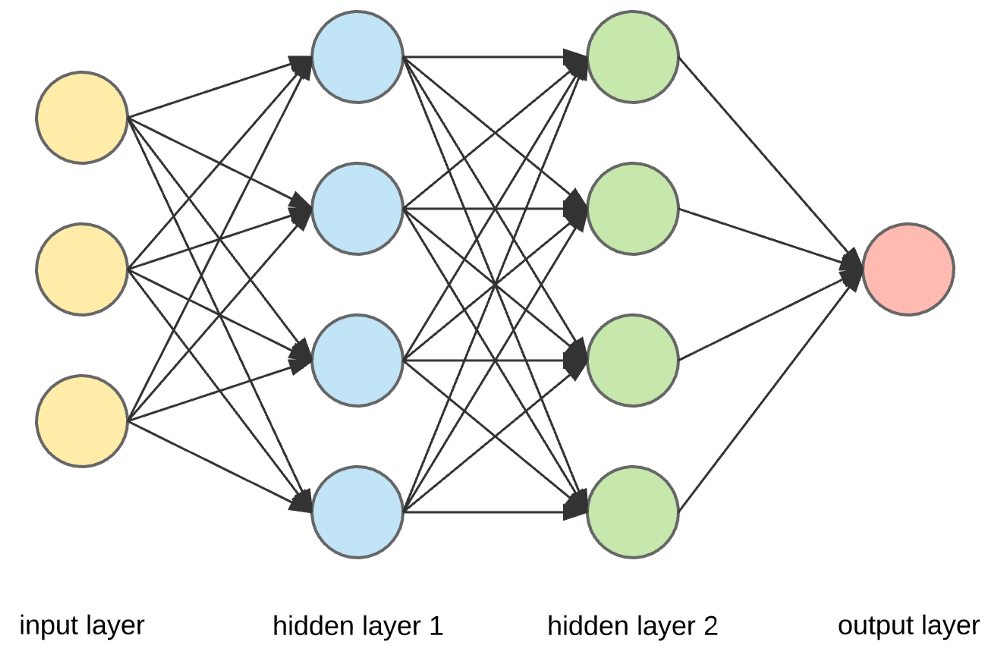

Mathematically, a neural network defines a function:

$$
f(x; \theta) = f_L \circ f_{L-1} \circ \cdots \circ f_1(x)
$$

where:
- $ x $ is the input,
- $ \theta $ denotes all model parameters (weights and biases),
- $ f_\ell $ is the function computed at layer $ \ell $,
- $ L $ is the number of layers.

Neural networks are particularly effective at modeling **nonlinear and high-dimensional** data.

---

###  Why Neural Networks?

Neural networks are **"universal function approximators"**: with enough layers and neurons, they can approximate any continuous function to arbitrary accuracy (under mild conditions). In practice, they provide:

- High flexibility for modeling nonlinear relationships
- Scalability to high-dimensional inputs
- Customizability through architectural design


---

### Neural Network Taxonomy (High-Level)

Neural networks come in many architectural forms. Here is a basic taxonomy to situate where we are starting:

| Type                     | Description                                         | When Used                                 |
|--------------------------|-----------------------------------------------------|--------------------------------------------|
| **Fully Connected (FC)** | Each neuron is connected to all neurons in next layer | Generic tabular or flattened data         |
| **Convolutional (CNN)**  | Learns spatial filters for structured inputs (e.g., images) | Spatial/temporal data with local patterns |
| **Recurrent (RNN)**      | Maintains memory across sequences                  | Time series, language, signal processing   |
| **Graph (GNN)**          | Operates on non-Euclidean data structures          | Networks, meshes, unstructured grids       |
| **Transformers**         | Uses self-attention across inputs                  | Language, vision, spatiotemporal modeling  |
| **Neural Operators**     | Approximates operators instead of functions        | Dynamical systems, PDEs |

In this notebook, we begin with the most fundamental architecture: the **fully connected feedforward neural network**.



## 2. How Do Neural Networks Train? (High-Level Overview)

Neural networks learn by **adjusting their parameters (weights and biases)** to minimize a loss function that measures the discrepancy between the model's predictions and the true outputs.

This process is done using **iterative optimization**, typically via **gradient descent** and its variants.

---

### The Training Pipeline

The typical neural network training loop consists of the following steps:

1. **Initialization**  
   All weights and biases are randomly initialized (often using heuristics like Xavier or He initialization).

2. **Forward Pass**  
   The input data is passed through the network to compute predictions $ \hat{y} = f(x; \theta) $.

3. **Loss Computation**  
   The model's output is compared to the true output using a loss function, e.g.:
   - Mean Squared Error (regression)
   - Cross-Entropy Loss (classification)

4. **Backward Pass (Backpropagation)**  
   Gradients of the loss with respect to each parameter are computed via the chain rule, using a procedure called **backpropagation**.

5. **Parameter Update**  
   Parameters are updated using the gradient and a **learning rate** $ \eta $:
   $$
   \theta \leftarrow \theta - \eta \frac{\partial \text{Loss}}{\partial \theta}
   $$

6. **Repeat**  
   This process is repeated over many *epochs* until the model converges or early stopping criteria are met.

**Importantly:** Modern Deep learning packages like Pytorch do all this computation for you.  All you need to do is specificy archeticture and hyperparameters. 

---

### Key Concepts

- **Epoch**: One complete pass over the training dataset.
- **Batch**: A subset of data used for one parameter update step.
- **Learning Rate**: Step size used in gradient descent; a key hyperparameter.
- **Overfitting**: When the model fits training data well but performs poorly on unseen data. Regularization and validation are used to mitigate this.

---

### Analogy with Linear Models

- Linear regression solves for weights $\beta$ analytically.  
- Neural networks **must be trained iteratively**, using optimization techniques that scale to complex, nonlinear models.

In the next section, we will define a fully connected feedforward neural network in detail, and implement one using PyTorch.


## 3. Fully Connected Neural Networks (FCNNs)

A **fully connected neural network**, also called a **multilayer perceptron (MLP)**, is the simplest and most widely used neural network architecture. It consists of a sequence of layers where every neuron in one layer is connected to every neuron in the next.

---

### Architecture

A typical FCNN for regression consists of:

1. **Input Layer**  
   - Receives the input vector $ x \in \mathbb{R}^d $.  
   - In our case, $ x $ is a flattened spatial field from one time step (e.g., shape = `(10988,)`).

2. **Hidden Layers**  
   - Each hidden layer applies a linear transformation followed by a **nonlinear activation function**:
     $$
     h^{(l)} = \sigma(W^{(l)} h^{(l-1)} + b^{(l)})
     $$
   - Common activations: ReLU, Tanh, Sigmoid.

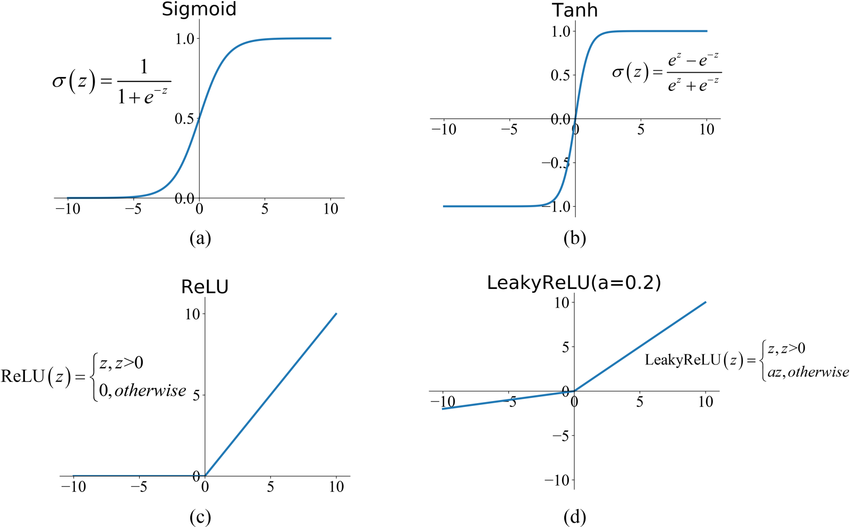

3. **Output Layer**  
   - Outputs a scalar (e.g., temperature at a specific location).
   - For regression, the final activation is often identity (no activation).

---

### GPUs?

Training deep learning models can be computationally expensive, especially with large numbers of features or large batch sizes. Modern deep learning frameworks like PyTorch support GPU acceleration using **CUDA** (NVIDIA’s parallel computing platform).

Benefits of using a GPU:
- **Faster training** via parallelized matrix operations.
- **Scalability** to larger models or datasets.
- Easy to switch between CPU and GPU with minimal code changes.

In PyTorch, you can move both your model and data to the GPU using:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```
---

# Training Neural Networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Load SST Dataset

In [ ]:
## From last notebooks:

# Load SST dataset (monthly data from 1854 onward)
ds = xr.tutorial.load_dataset('ersstv5')
sst = ds['sst']  # Shape: (time, lat, lon)

# Reshape: (time, lat, lon) → (time, n_pixels)
n_time, n_lat, n_lon = sst.shape
X_full = sst.values.reshape(n_time, n_lat * n_lon)

# Remove grid points with any NaNs
valid_mask = ~np.any(np.isnan(X_full), axis=0)
X_full = X_full[:, valid_mask]  # Shape: (time, n_valid_points)

# Create supervised (X_t, X_{t+1}) pairs
X = X_full[:-1]
y = X_full[1:]

# Time-aware train/test split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

### Convert Data to Tensors and Move to GPU

Before training a neural network in PyTorch, we need to convert our NumPy arrays into **PyTorch tensors**, which are the core data structure for computation.

We also move these tensors to the appropriate device (either a **GPU** if one is available, or the **CPU** otherwise). This ensures that both the model and data live on the same hardware during training.


In [ ]:
# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [ ]:
# #  Standardize inputs and outputs
# x_scaler = StandardScaler()
# y_scaler = StandardScaler()

# X_train = x_scaler.fit_transform(X_train)
# X_test = x_scaler.transform(X_test)

# y_train = y_scaler.fit_transform(y_train)
# y_test = y_scaler.transform(y_test)

## Define Neural Network

### Define a Simple Feedforward Neural Network

This model is a fully connected (dense) neural network that learns to predict the next time slice of sea surface temperature (SST) from the current one.

- The model consists of three linear layers:
  - The **input layer** takes a flattened SST field as input.
  - The **hidden layers** each use a `ReLU` activation function to introduce nonlinearity.
  - The **output layer** returns a vector of the same size as the input, representing the predicted SST at the next time step.

We define the model as a subclass of `nn.Module`, which is the base class for all PyTorch models.


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size)  # Predict next SST slice
        )

    def forward(self, x):
        return self.net(x)

### Initialize the Model, Loss Function, and Optimizer

- **`input_size`** is set to the number of spatial points (i.e., grid cells) we're predicting for.
- We create an instance of the `SimpleNN` model and move it to the correct device (GPU or CPU).
- The **loss function** is Mean Squared Error (`nn.MSELoss`), which measures how close the predicted SST field is to the true one. It’s a common choice for regression tasks.
- We use the **Adam optimizer**, a popular gradient-based optimizer that adapts learning rates during training. The learning rate (`lr`) controls how quickly the model updates its weights.


In [ ]:
# Create model, loss function, and optimizer
input_size = X_train.shape[1]
model = SimpleNN(input_size=input_size).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Training the Model

This loop trains the neural network for a fixed number of epochs (100 in this case).

Each epoch involves:

- **`model.train()`**: Sets the model to training mode (important if using dropout or batch norm).
- **`optimizer.zero_grad()`**: Clears old gradients from the previous step.
- **Forward pass**: The model predicts the SST at the next time step from the current input.
- **Loss computation**: We calculate how far off the prediction is from the true value using MSE loss.
- **Backward pass**: `loss.backward()` computes gradients of the loss with respect to model weights.
- **Optimization step**: `optimizer.step()` updates the weights using the computed gradients.

Every 10 epochs, the current loss is printed to monitor training progress.


In [ ]:
# Training loop
n_epochs = 100
train_losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}, Loss: {loss.item():.4f}")


### Evaluate the Model on Test Data

After training, we evaluate the model’s performance on the unseen test set:

- **`model.eval()`** puts the model in evaluation mode, disabling behaviors like dropout.
- **`with torch.no_grad()`** tells PyTorch not to compute gradients, which speeds up evaluation and reduces memory usage.
- The model predicts the SST at the next time step for the test data, and we compute the **Mean Squared Error (MSE)** between the predictions and the ground truth.

The final test loss is printed, giving a measure of how well the model generalizes to new data.


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = loss_fn(y_pred_test, y_test_tensor)

print(f"\nTest Loss (MSE): {test_loss.item():.4f}")


### Plot the results

#### Spatial Error Maps

First lets look at spatial-temporal maps as before

In [ ]:
def plot_sst_sample(sample_idx, y_test, y_pred, valid_mask, ds, X):
    """
    Visualize true vs. predicted Sea Surface Temperature (SST) for a given test sample.

    Parameters:
        sample_idx (int): Index of the test sample to visualize.
        y_test (torch.Tensor or np.ndarray): Ground truth SST values (flattened, masked).
        y_pred (torch.Tensor or np.ndarray): Predicted SST values (flattened, masked).
        valid_mask (np.ndarray): Boolean mask indicating ocean points (True) vs land (False).
        ds (xarray.Dataset): Original dataset with dimensions and time metadata.
        X (np.ndarray): Full input array used to infer time indexing.
    """
    # Safely get dimensions
    n_lat = ds.sizes['lat']
    n_lon = ds.sizes['lon']

    # Ensure inputs are numpy arrays
    if torch.is_tensor(y_test):
        y_test = y_test.detach().cpu().numpy()
    if torch.is_tensor(y_pred):
        y_pred = y_pred.detach().cpu().numpy()

    # Get test sample
    y_true_sample = y_test[sample_idx]
    y_pred_sample = y_pred[sample_idx]

    # Initialize full arrays with NaNs
    sst_true_full = np.full((n_lat * n_lon,), np.nan)
    sst_pred_full = np.full((n_lat * n_lon,), np.nan)
    sst_resid_full = np.full((n_lat * n_lon,), np.nan)

    # Fill valid ocean values
    sst_true_full[valid_mask] = y_true_sample
    sst_pred_full[valid_mask] = y_pred_sample
    sst_resid_full[valid_mask] = y_true_sample - y_pred_sample

    # Reshape to (lat, lon)
    sst_true_grid = sst_true_full.reshape(n_lat, n_lon)
    sst_pred_grid = sst_pred_full.reshape(n_lat, n_lon)
    sst_resid_grid = sst_resid_full.reshape(n_lat, n_lon)

    # Compute corresponding time
    n_total_samples = X.shape[0]
    n_train = int(0.8 * n_total_samples)
    time_selected = ds['time'].values[n_train + sample_idx + 1]  # +1 for prediction lag

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    sns.heatmap(sst_true_grid, ax=axes[0], cmap='coolwarm', cbar=True)
    axes[0].set_title("True SST")

    sns.heatmap(sst_pred_grid, ax=axes[1], cmap='coolwarm', cbar=True)
    axes[1].set_title("Predicted SST")

    sns.heatmap(sst_resid_grid, ax=axes[2], cmap='bwr', center=0, cbar=True)
    axes[2].set_title("Residual (True - Predicted)")

    plt.suptitle("Sea Surface Temperature Prediction vs. Truth", fontsize=18, y=1.05)

    # Add time annotation
    time_str = np.datetime_as_string(time_selected, unit='M')
    fig.text(0.5, -0.05, f"Month Predicted: {time_str}", ha='center', fontsize=18)

    plt.tight_layout()
    plt.show()

In [ ]:
sample_idx=1

plot_sst_sample(sample_idx, y_test=y_test_tensor, y_pred=model(X_test_tensor), valid_mask=valid_mask, ds=ds, X=X_full)

#### Comparing Temporal Variability: True vs Predicted SST

This next plot shows the **L2 norm of change between consecutive time slices** for both the true SST data and the model predictions. In other words, it measures how much the sea surface temperature field changes from one time step to the next:

- **True Temporal Change**: The actual variation observed in the real data.
- **Predicted Temporal Change**: How much the model’s output changes from one step to the next.
- **Difference**: The gap between the two — if consistently positive, it suggests that the model is underestimating variability (i.e., producing smoother predictions).

This diagnostic helps identify whether the neural network is capturing real dynamics or just learning a damped average.

In [ ]:
# Detach from GPU
with torch.no_grad():
    y_pred = model(X_test_tensor).detach().cpu().numpy()
    y_true = y_test_tensor.detach().cpu().numpy()


# Compute L2 norm of changes between time steps
delta_true = np.linalg.norm(y_true[1:] - y_true[:-1], axis=1)
delta_pred = np.linalg.norm(y_pred[1:] - y_pred[:-1], axis=1)

# Difference in magnitude of changes
delta_diff = delta_true - delta_pred


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(delta_true, label='True Temporal Change (||y[t+1] - y[t]||)')
plt.plot(delta_pred, label='Predicted Temporal Change')
plt.plot(delta_diff, label='Difference (True - Pred)', linestyle='--', color='gray')
plt.xlabel("Time Step Index")
plt.ylabel("L2 Norm of Change")
plt.title("Temporal Variability: True vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Exercises

Try updating the NN parameters. Suggestions:

1. Remove a layer from the NN.  What happened with the performance?
2. Make the NN layer(s) wider or shallower.  What happened with performance?
3. What happens if you increase the number of epochs?  Can you improve performance?
4. Adjust the learning rate, see what happens. 